# This notebook is for the development of a pipeline for unsupervised learning on accelerometer data. 

## Pyhsmm is tested on the SMOVE dataset.

### Part 0: Imports

In [1]:
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import math
import numpy as np
import pandas as pd
import pyhsmm
import pyhsmm.basic.distributions as distributions
from pyhsmm.util.text import progprint_xrange
from scipy import stats
import statistics 

### Part 1: Data parsing

In [2]:
data_location = "/home/jack/data/SMOVE_dataset_0.2"

# Creates strings for parsing over the file structure of the dataset
participant_IDs = ["P" + str(x) for x in range(4,9)]

In [3]:
# The data from each participant is stored into a dictionary
SMOVE_data = {}
for participant in participant_IDs:
    SMOVE_data[participant] = pd.read_pickle(r'{0}/acc_data_{1}.pickle'.format(data_location, participant))

In [4]:
# The data from the different devices are stored as a dictionary.
for device in SMOVE_data["P4"]:
    print(device)

# Example of the data from a device
SMOVE_data["P4"]["waist"]

waist
lower_back
left_wrist
right_wrist
left_upper_arm
right_upper_arm
left_shank
right_shank
left_thigh
right_thigh
sternum


timestamp      accX      accY      accZ  label
0             0.0 -9.507906 -0.180554 -1.647339    0.0
1            20.0 -9.465234 -0.143903 -1.753500    0.0
2            40.0 -9.448027 -0.279861 -1.953387    0.0
3            60.0 -9.425528 -0.234681 -2.000758    0.0
4            80.0 -9.458136 -0.220903 -1.990725    0.0
...           ...       ...       ...       ...    ...
186815  3736300.0 -8.400777  0.206534 -4.467836    0.0
186816  3736320.0 -8.400777  0.206534 -4.467836    0.0
186817  3736340.0 -8.400777  0.206534 -4.467836    0.0
186818  3736360.0 -8.400777  0.206534 -4.467836    0.0
186819  3736380.0 -8.400777  0.206534 -4.467836    0.0

[186820 rows x 5 columns]

In [84]:
used_devices = ["right_thigh", "sternum", "left_wrist"]

### Part 2: Basic plotting

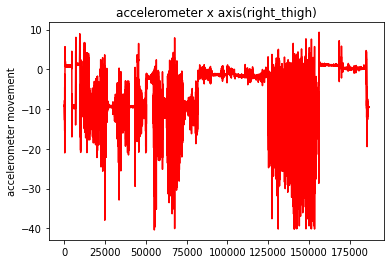

In [5]:
plt.plot(SMOVE_data["P4"]["right_thigh"]["accX"], color="red")
plt.title("accelerometer x axis(right_thigh)")
plt.ylabel("accelerometer movement")
plt.show()

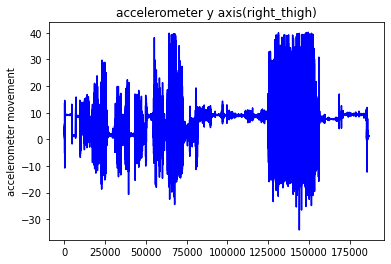

In [6]:
plt.plot(SMOVE_data["P4"]["right_thigh"]["accY"], color="blue")
plt.title("accelerometer y axis(right_thigh)")
plt.ylabel("accelerometer movement")
plt.show()

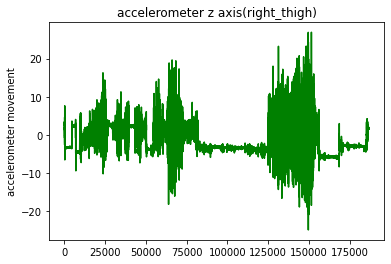

In [7]:
plt.plot(SMOVE_data["P4"]["right_thigh"]["accZ"], color="green")
plt.title("accelerometer z axis(right_thigh)")
plt.ylabel("accelerometer movement")
plt.show()

### Part 3: Windows

The data of each participant is split into windows of a certain amount of seconds

In [8]:
def split_into_windows(data, nrows_per_window):
    # Splits input data into windows based on given amount of rows per window.
    return [data[i:i+nrows_per_window] for i in range(0,data.shape[0],nrows_per_window)]

In [9]:
# The sampling rate of the devices
hertz = 50
# the size of the windows in seconds
window_length = 5
nrows_per_window = int(window_length / (1 / hertz))

In [87]:
windowed_data = {}
all_windows_per_dev = {}
for participant in SMOVE_data:
    windows_per_dev = {}
    for device in used_devices:
        windows = split_into_windows(SMOVE_data[participant][device], nrows_per_window)
        windows_per_dev[device] =  windows
        try:
            all_windows_per_dev[device] +=  windows
        except KeyError:
            all_windows_per_dev[device] = windows
    windowed_data[participant] = windows_per_dev

### Part 4: Features

In [11]:
def calc_ENMO(x, y, z):
    # Returns the Euclidean Norm Minus One (ENMO). Calculated from three given values: X, Y and Z
    total_accel = math.sqrt(x**2 + y**2 + z**2)
    return np.clip(total_accel - 1, 0, None)


def calc_mean_ENMO(dataset):
    # Returns the mean total acceleration of a given set of data
    return statistics.mean(dataset.apply(lambda row: calc_ENMO(row["accX"],
                                                               row["accY"],
                                                               row["accZ"]), axis=1))


def calc_sensor_orientation(main_axis, second_axis, third_axis):
    # Returns the orientation of a accelerometer sensor axis relative to the horizontal plane.
    return math.degrees(math.atan(main_axis / math.sqrt(second_axis**2 + third_axis**2)))


def calc_mean_sensor_orientation(dataset, main_axis, second_axis, third_axis):
    # Returns the mean the orientation of a accelerometer sensor axis relative to the horizontal plane.
    return statistics.mean(dataset.apply(lambda row: calc_sensor_orientation(row["acc{}".format(main_axis)],
                                                                             row["acc{}".format(second_axis)],
                                                                             row["acc{}".format(third_axis)]), axis=1))


def extract_features(dataset):
    # returns the extracted features from the given dataset
    mean_ENMO = calc_mean_ENMO(dataset)
    mean_angle_x = calc_mean_sensor_orientation(dataset, "X", "Y", "Z")
    mean_angle_y = calc_mean_sensor_orientation(dataset, "Y", "X", "Z")
    mean_angle_z = calc_mean_sensor_orientation(dataset, "Z", "Y", "X")    
    return [mean_ENMO, mean_angle_x, mean_angle_y, mean_angle_z]


def get_minmax(input_list):
    # Returns the minimum and maximum of a given list
    return [min(input_list), max(input_list)]
    
    
def minmax_norm(x, xmin, xmax):
    # Normalizes data(x) using the min max approach, given the minimum and maximum of the total data
    return ((x - xmin) / (xmax - xmin))

In [88]:
# The minimum and maximum values of the features are calculated for each device.
# This is needed for min max normalization

min_max_data = {}

for device in all_windows_per_dev:
    device_windows = all_windows_per_dev[device]

    ENMO_list = [calc_mean_ENMO(window) for window in device_windows]
    angle_x_list = [calc_mean_sensor_orientation(window, "X", "Y", "Z") for window in device_windows]
    angle_y_list = [calc_mean_sensor_orientation(window, "Y", "X", "Z") for window in device_windows]
    angle_z_list = [calc_mean_sensor_orientation(window, "Z", "Y", "X") for window in device_windows]

    min_max_data[device+"min_ENMO"], min_max_data[device+"max_ENMO"] = get_minmax(ENMO_list)
    min_max_data[device+"min_angle_x"], min_max_data[device+"max_angle_x"] = get_minmax(angle_x_list)
    min_max_data[device+"min_angle_y"], min_max_data[device+"max_angle_y"] = get_minmax(angle_y_list)
    min_max_data[device+"min_angle_z"], min_max_data[device+"max_angle_z"] = get_minmax(angle_z_list)

In [91]:
features = {}
for participant in windowed_data:
    features_per_dev = {}
    for device in windowed_data[participant]:
        
        ENMO_list = []
        anglex_list = []
        angley_list = []
        anglez_list = []
        labels = []
        timestamps = []

        for window in windowed_data[participant][device]:
            # the label for the window is the mode of the labels in the window
            labels.append(stats.mode(window["label"].to_numpy())[0][0])
            # the timestamp for the window is the initial timestamp
            timestamps.append(window["timestamp"].iloc[0])

            enmo, anglex, angley, anglez = extract_features(window)

            ENMO_list.append(enmo)
            anglex_list.append(anglex)
            angley_list.append(angley)
            anglez_list.append(anglez)
        
        feature_data = {}
        feature_data["ENMO"] = [minmax_norm(ENMO, 
                                            min_max_data[device+"min_ENMO"], 
                                            min_max_data[device+"max_ENMO"]) for ENMO in ENMO_list]
        
        feature_data["anglex"] = [minmax_norm(anglex,
                                              min_max_data[device+"min_angle_x"],
                                              min_max_data[device+"max_angle_x"]) for anglex in anglex_list]
        
        feature_data["angley"] = [minmax_norm(angley,
                                              min_max_data[device+"min_angle_y"],
                                              min_max_data[device+"max_angle_y"]) for angley in angley_list]
        
        feature_data["anglez"] = [minmax_norm(anglez,
                                              min_max_data[device+"min_angle_z"],
                                              min_max_data[device+"max_angle_z"]) for anglez in anglez_list]
        feature_data["label"] = labels
        

        # The features are put into a new dataframe
        features_per_dev[device] = pd.DataFrame(feature_data, index= timestamps)

    features[participant] = features_per_dev

### Combining the features of the devices

In [114]:
features_comb_devs = {}
labels = {}
for participant in features:
    feature_data = {}
    for device in features[participant]:
        feature_data[device+"_ENMO"] = features[participant][device]["ENMO"]
        feature_data[device+"_anglex"] = features[participant][device]["anglex"]
        feature_data[device+"_angley"] = features[participant][device]["angley"]
        feature_data[device+"_anglez"] = features[participant][device]["anglez"]
    labels["label"] = features[participant][used_devices[0]]["label"]
    features_comb_devs[participant] = pd.DataFrame(feature_data)

In [107]:
data_example = features["P4"]["right_thigh"]
data_example.head()

ENMO    anglex    angley    anglez  label
0.0      0.171385  0.118737  0.258163  0.543300    0.0
5000.0   0.119792  0.475958  0.626272  0.337458    0.0
10000.0  0.066199  0.613919  0.810063  0.220716    0.0
15000.0  0.066851  0.598431  0.820968  0.223322  201.0
20000.0  0.066307  0.597441  0.818254  0.219889  201.0

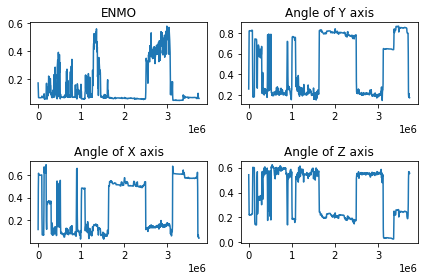

In [15]:
fig, ax = plt.subplots(2, 2)

ax[0,0].title.set_text('ENMO')
ax[0,0].plot(data_example["ENMO"])

ax[1,0].title.set_text('Angle of X axis')
ax[1,0].plot(data_example["anglex"])

ax[0,1].title.set_text('Angle of Y axis')
ax[0,1].plot(data_example["angley"])

ax[1,1].title.set_text('Angle of Z axis')
ax[1,1].plot(data_example["anglez"])

fig.tight_layout()

In [16]:
# This is how data fend into the model looks like
data_example_no_labels = data_example.iloc[0:, 0:4]
data_example_no_labels.head()

ENMO    anglex    angley    anglez
0.0      0.171385  0.118737  0.258163  0.543300
5000.0   0.119792  0.475958  0.626272  0.337458
10000.0  0.066199  0.613919  0.810063  0.220716
15000.0  0.066851  0.598431  0.820968  0.223322
20000.0  0.066307  0.597441  0.818254  0.219889

<AxesSubplot:>

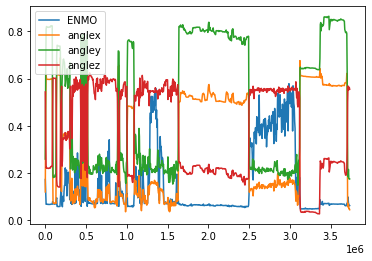

In [17]:
data_example_no_labels.plot()

### Part 5: PyHSMM testing

### Initial run

The parameters for this inital run follows what is recommended by the pyhsmm github.
Taken from examples/hsmm.py

In [121]:
# Dimension of the input data
obs_dim = len(features_comb_devs[participant_IDs[0]].columns)
# Max number of states generated
Nmax = 25

In [122]:
obs_hypparams = {'mu_0':np.zeros(obs_dim),
                'sigma_0':np.eye(obs_dim),
                'kappa_0':0.25,
                'nu_0':obs_dim+2}
dur_hypparams = {'alpha_0':2*30,
                 'beta_0':2}

In [123]:
obs_distns = [distributions.Gaussian(**obs_hypparams) for state in range(Nmax)]
dur_distns = [distributions.PoissonDuration(**dur_hypparams) for state in range(Nmax)]

In [124]:
run1_posteriormodel = pyhsmm.models.WeakLimitHDPHSMM(
        alpha=6.,gamma=6., # these can matter; see concentration-resampling.py
        init_state_concentration=6., # pretty inconsequential
        obs_distns=obs_distns,
        dur_distns=dur_distns)

In [125]:
for participant in features_comb_devs:
    run1_posteriormodel.add_data(features_comb_devs[participant])

In [126]:
for idx in progprint_xrange(150):
    run1_posteriormodel.resample_model()

.........................  [  25/150,    9.60sec avg, ETA 20:00 ]
.........................  [  50/150,    9.50sec avg, ETA 15:50 ]
.........................  [  75/150,    9.47sec avg, ETA 11:50 ]
.........................  [ 100/150,    9.45sec avg, ETA 07:53 ]
.........................  [ 125/150,    9.45sec avg, ETA 03:56 ]
.........................  [ 150/150,    9.44sec avg, ETA 0.00 ]

   9.44sec avg, 23:36 total



<Figure size 432x288 with 0 Axes>

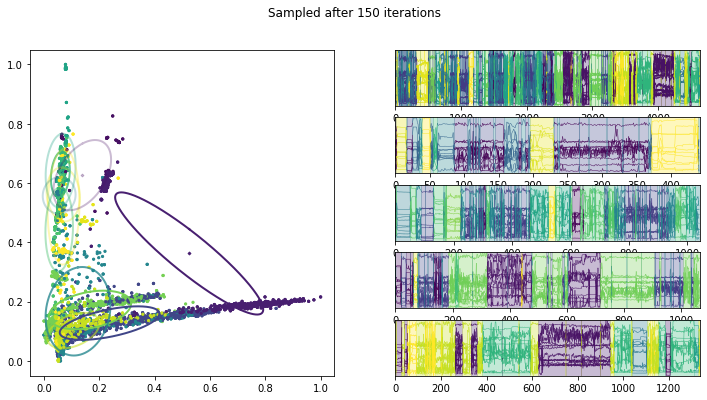

In [127]:
plt.figure()
run1_posteriormodel.plot()
plt.gcf().suptitle('Sampled after 150 iterations')
plt.show()

In [25]:
label_color_dict = {0.0 : "#E000FF",   # (Purple) Lab taks 
                    1.0 : "#BD00D7",   #   - 8m
                    2.0 : "#9E00B4",   #   - L-task
                    3.0 : "#830095",   #   - Irregular_walking
                    4.0 : "#630070",   #   - 8-task
                    100.0 : "#F4D4FF", # (pink) Lying
                    199.0 : "#F4D4FF", #   - Other_lying (ex. chekcing phone)
                    200.0 : "#0055FF", # (Blue) Sitting 
                    201.0 : "#0055FF", #    - Sitting_lying (couch)
                    219.0 : "#0055FF", #       - Sitting_lying_others
                    220.0 : "#0055FF", #    - Sitting_straight
                    221.0 : "#0055FF", #       - Eating 
                    222.0 : "#0055FF", #       - Sitting_cooking
                    223.0 : "#0055FF", #       - Playing_cards
                    224.0 : "#0055FF", #       - Computer_working
                    225.0 : "#0055FF", #       - Putting_shoes
                    226.0 : "#0055FF", #       - Checking_phone
                    299.0 : "#0055FF", #    - Sitting_others
                    300.0 : "#00F3FF", # (Cyan) Cycling
                    400.0 : "#13FF00", # (Green) Standing
                    401.0 : "#13FF00", #    - Standing_cooking
                    402.0 : "#13FF00", #    - Standing_holding_something
                    403.0 : "#13FF00", #    - Standing_getting_dress
                    499.0 : "#13FF00", #    - Standing_others
                    500.0 : "#FFF300", # (Yellow) Moving_around
                    501.0 : "#FFF300", #    - Cooking
                    502.0 : "#FFF300", #    - Doing_dishes
                    503.0 : "#FFF300", #    - Cleaning_floor
                    504.0 : "#FFF300", #    - Moving_carrying_something
                    505.0 : "#FFF300", #    - Opening_closing_door
                    599.0 : "#FFF300", #    - Moving_around_others
                    600.0 : "#FFAA00", # (Orange) Walking
                    601.0 : "#FFAA00", #    - Upstairs 
                    602.0 : "#FFAA00", #    - Downstairs
                    603.0 : "#FFAA00", #    - Walking_holding_something
                    699.0 : "#FFAA00", #    - Walking_others
                    700.0 : "#FF0000", # (Red) Other activities
                    701.0 : "#FF0000", #    - Putting_pants_sitting_to_standing
                    702.0 : "#FF0000", #    - Putting_shoes_kneeling
                    800.0 : "#000000"} # (Black) Other events

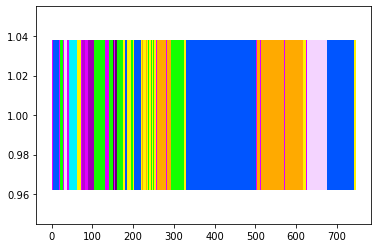

In [26]:
# construct some data
labels = features["P4"]["label"]
n = len(labels)
x = np.arange(n+1)           # resampledTime
y = "1" * n   # modulusOfZeroNormalized

# set up colors 
c = [label_color_dict[x] for x in labels]

# convert time series to line segments
lines = [((x0,y0), (x1,y1)) for x0, y0, x1, y1 in zip(x[:-1], y[:-1], x[1:], y[1:])]
colored_lines = LineCollection(lines, colors=c, linewidths=(150,))

# Creates a plot that shows the label for each window.
fig, ax = plt.subplots(1)
ax.add_collection(colored_lines)
ax.autoscale_view()
plt.show()

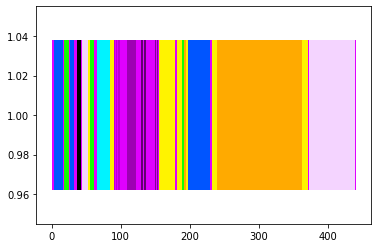

In [27]:
# construct some data
labels = features["P5"]["label"]
n = len(labels)
x = np.arange(n+1)           # resampledTime
y = "1" * n   # modulusOfZeroNormalized

# set up colors 
c = [label_color_dict[x] for x in labels]

# convert time series to line segments
lines = [((x0,y0), (x1,y1)) for x0, y0, x1, y1 in zip(x[:-1], y[:-1], x[1:], y[1:])]
colored_lines = LineCollection(lines, colors=c, linewidths=(150,))

# Creates a plot that shows the label for each window.
fig, ax = plt.subplots(1)
ax.add_collection(colored_lines)
ax.autoscale_view()
plt.show()

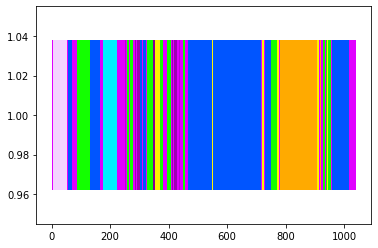

In [28]:
# construct some data
labels = features["P6"]["label"]
n = len(labels)
x = np.arange(n+1)           # resampledTime
y = "1" * n   # modulusOfZeroNormalized

# set up colors 
c = [label_color_dict[x] for x in labels]

# convert time series to line segments
lines = [((x0,y0), (x1,y1)) for x0, y0, x1, y1 in zip(x[:-1], y[:-1], x[1:], y[1:])]
colored_lines = LineCollection(lines, colors=c, linewidths=(150,))

# Creates a plot that shows the label for each window.
fig, ax = plt.subplots(1)
ax.add_collection(colored_lines)
ax.autoscale_view()
plt.show()

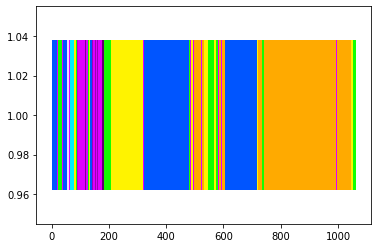

In [29]:
# construct some data
labels = features["P7"]["label"]
n = len(labels)
x = np.arange(n+1)           # resampledTime
y = "1" * n   # modulusOfZeroNormalized

# set up colors 
c = [label_color_dict[x] for x in labels]

# convert time series to line segments
lines = [((x0,y0), (x1,y1)) for x0, y0, x1, y1 in zip(x[:-1], y[:-1], x[1:], y[1:])]
colored_lines = LineCollection(lines, colors=c, linewidths=(150,))

# Creates a plot that shows the label for each window.
fig, ax = plt.subplots(1)
ax.add_collection(colored_lines)
ax.autoscale_view()
plt.show()

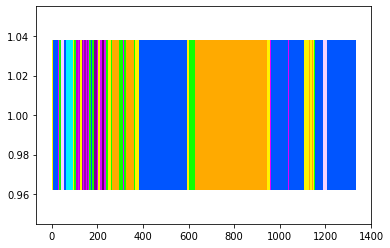

In [30]:
# construct some data
labels = features["P8"]["label"]
n = len(labels)
x = np.arange(n+1)           # resampledTime
y = "1" * n   # modulusOfZeroNormalized

# set up colors 
c = [label_color_dict[x] for x in labels]

# convert time series to line segments
lines = [((x0,y0), (x1,y1)) for x0, y0, x1, y1 in zip(x[:-1], y[:-1], x[1:], y[1:])]
colored_lines = LineCollection(lines, colors=c, linewidths=(150,))

# Creates a plot that shows the label for each window.
fig, ax = plt.subplots(1)
ax.add_collection(colored_lines)
ax.autoscale_view()
plt.show()